In [67]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

In [85]:
FS = 50

In [161]:
def generate_combine_piano_roll(midi_data, fs):
    mat = None
    for inst in midi_data.instruments:
        print(inst)
        if (inst.is_drum == False):
            if (mat is None):
                mat = inst.get_piano_roll(fs=fs)
            else:
                mat += inst.get_piano_roll(fs=fs)

    mat[mat > 0] = 1
    return mat

# Split into 10 seconds chunks
def split_sample(sample, length, sliding_factor):
    (pitch_level, time_steps) = sample.shape
    n_samples = int(time_steps / length * sliding_factor)
    print(n_samples)
    samples = np.zeros((n_samples, pitch_level, length))
    for i in range(0, n_samples):
        start = int(i * length / sliding_factor)
        end = start + length
        samples[i] = sample[:,start:end]
    return samples

def split_sample(sample, length, n_samples):
    (pitch_level, time_steps) = sample.shape
    samples = np.zeros((n_samples, pitch_level, length))
    max_start = time_steps - length
    for i in range(0, n_samples):
        start = int(i * max_start / n_samples)
        end = start + length
        samples[i] = sample[:,start:end]
    return samples

Instrument(program=0, is_drum=False, name="Right Hand")
Instrument(program=0, is_drum=False, name="Left Hand")
(128, 3888)


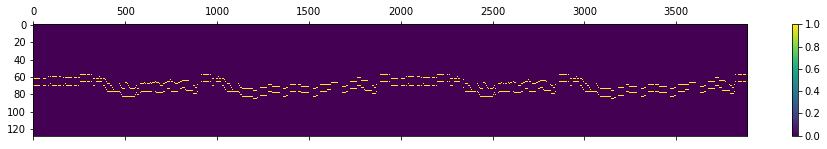

In [135]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

midi_data = pretty_midi.PrettyMIDI('data/Zelda_Overworld.mid')

mat = generate_combine_piano_roll(midi_data, FS)
print(mat.shape)
cax = plt.matshow(mat, aspect="auto")
plt.colorbar(cax)
plt.show()

In [171]:
length = 512
samples = split_sample(mat, 512, 100)
new_track = np.concatenate(samples, axis=1)
#print(new_track.shape)
#pm = piano_roll_to_pretty_midi(new_track * 75, fs=FS, program=0)
#pm.write("pianoroll.mid")

(128, 51200)


In [94]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm
pm = piano_roll_to_pretty_midi(mat * 75, fs=FS, program=0)
pm.write("pianoroll.mid")

In [3]:
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

In [4]:
# Large amount of credit goes to:
# https://github.com/keras-team/keras-contrib/blob/master/examples/improved_wgan.py
# which I've used as a reference for this implementation

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self, img_rows, img_cols, channels, batch_size):
        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        self.batch_size = batch_size

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        return build_generator(self.latent_dim, self.channels)

    def build_critic(self):
        return build_discriminator(self.img_shape)

    def train(self, X_train, epochs, sample_interval=50):

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], self.batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        n_images = 1
        noise = np.random.normal(0, 1, (n_images, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        print("Generated shape", gen_imgs.shape)
        img = gen_imgs.reshape(128, 512)
        
        img[img < 0.1] = 0 # Remove some notes
        
        pm = piano_roll_to_pretty_midi(img * 75, fs=FS, program=0)
        pm.write("output/pianoroll-%d.mid" % epoch)
        
        cax = plt.matshow(img, aspect="auto")
        plt.colorbar(cax)
        plt.savefig("output/pianoroll-%d.png" % epoch)
        plt.close()


In [136]:
class DCGAN():
    def __init__(self, img_rows, img_cols, channels):
        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        return build_generator(self.latent_dim, self.channels)
    
    def build_discriminator(self):
        return build_discriminator(self.img_shape)

    def train(self, X_train, epochs, batch_size=128, save_interval=50):

        # Rescale -1 to 1
        #X_train = train_data / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select random batch
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        n_images = 1
        noise = np.random.normal(0, 1, (n_images, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        print("Generated shape", gen_imgs.shape)
        img = gen_imgs.reshape(128, 512)
        
        img[img < 0.1] = 0 # Remove some notes
        
        pm = piano_roll_to_pretty_midi(img * 75, fs=FS, program=0)
        pm.write("output/pianoroll-%d.mid" % epoch)
        
        cax = plt.matshow(img, aspect="auto")
        plt.colorbar(cax)
        plt.savefig("output/pianoroll-%d.png" % epoch)
        plt.close()

In [26]:
def build_generator(latent_dim, channels):

    model = Sequential()

    model.add(Dense(128 * 2 * 8, activation="relu", input_dim=latent_dim))
    model.add(Reshape((2, 8, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("sigmoid"))

    print("Generator model")
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [5]:
def build_discriminator(img_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(4,89), strides=2, input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(4,1), strides=2, padding="same"))
    #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(4,1), strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    #model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    #model.add(BatchNormalization(momentum=0.8))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    print("Discriminator model")
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [ ]:
(n_samples, pitch_level, time_span) = samples.shape
train_data = samples.reshape(n_samples, pitch_level, time_span, 1)

#dcgan = DCGAN(pitch_level,time_span,1)
#dcgan.train(train_data, epochs=1000, batch_size=64, save_interval=50)

wgan = WGANGP(pitch_level,time_span,1, batch_size=64)
wgan.train(train_data, epochs=30000, sample_interval=50)